In [659]:
import numpy as np
import pandas as pd
import patsy
import itertools

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, \
                 LassoCV, ElasticNetCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn import grid_search, datasets

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

We will look at data for Q1, Q2 of 2015 and then Q1, Q2 of 2016

In [660]:
pge_q1 = pd.read_csv("PGE_2015_Q1_ElectricUsageByZip.csv")
pge_q2 = pd.read_csv("PGE_2015_Q2_ElectricUsageByZip.csv")
pge_q3 = pd.read_csv("PGE_2015_Q3_ElectricUsageByZip.csv")
pge_q4 = pd.read_csv("PGE_2015_Q4_ElectricUsageByZip.csv")

In [661]:
pge_q1.tail()

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh
7686,96125,3,2015,Elec- Residential,N,365,"77,890",213
7687,96137,3,2015,Elec- Commercial,Y,0,0,NaN
7688,96137,3,2015,Elec- Residential,N,"2,687","761,436",283
7689,96161,3,2015,Elec- Commercial,Y,0,0,NaN
7690,96161,3,2015,Elec- Residential,Y,0,0,NaN


In [662]:
pge_q2.tail()

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh
7708,96125,6,2015,Elec- Residential,N,366,"83,776",229
7709,96137,6,2015,Elec- Commercial,Y,0,0,NaN
7710,96137,6,2015,Elec- Residential,N,"2,701","988,483",366
7711,96161,6,2015,Elec- Commercial,Y,0,0,NaN
7712,96161,6,2015,Elec- Residential,Y,0,0,NaN


In [663]:
pge_q1_df = pd.DataFrame(pge_q1)
pge_q2_df = pd.DataFrame(pge_q2)
pge_q3_df = pd.DataFrame(pge_q3)
pge_q4_df = pd.DataFrame(pge_q4)

In [664]:
pge_q1_df.shape, pge_q2_df.shape, pge_q3_df.shape, pge_q4_df.shape

((7691, 8), (7713, 8), (7741, 8), (7733, 8))

In [665]:
pge_q = pd.concat([pge_q1_df, pge_q2_df, pge_q3_df, pge_q4_df])

In [666]:
pge_q.shape

(30878, 8)

In [667]:
pge_q = pge_q.sample(frac=0.10)

In [654]:
pge_q.shape

(3088, 8)

In [668]:
pge_q.head(3)


,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh
1516,95251,1,2015,Elec- Residential,N,279,"204,611",733
6612,95212,12,2015,Elec- Commercial,N,232,"2,480,565","10,692"
4229,95374,2,2015,Elec- Agricultural,Y,0,0,NaN


In [669]:
pge_q.columns = [x.replace(',','') for x in pge_q.columns]

In [670]:
pge_q['AveragekWh']  = [ np.nan_to_num(x) for x in  pge_q['AveragekWh']]

In [671]:
pge_q.tail()

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh
6812,95385,3,2015,Elec- Residential,N,93,"57,318",616
3211,94030,11,2015,Elec- Commercial,N,425,"3,215,464","7,566"
3954,95125,8,2015,Elec- Agricultural,Y,0,0,0
3625,94607,5,2015,Elec- Industrial,Y,0,0,0
297,93607,7,2015,Elec- Agricultural,N,25,"1,738,078","69,523"


In [672]:
pge_q.TotalkWh = [(x.replace(',','')) for x in pge_q.TotalkWh]

In [673]:
pge_q.Combined = pge_q.Combined.map(lambda x: 1 if x == 'N' else 0)

In [674]:
pge_q.tail(3)

,ZipCode,Month,Year,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh
3954,95125,8,2015,Elec- Agricultural,0,0,0,0
3625,94607,5,2015,Elec- Industrial,0,0,0,0
297,93607,7,2015,Elec- Agricultural,1,25,1738078,"69,523"


In [675]:
pge_q.CustomerClass.unique()

array(['Elec- Residential', 'Elec- Commercial', 'Elec- Agricultural',
       'Elec- Industrial'], dtype=object)

In [676]:
def cust_clean(x):
    
    if x == 'Elec- Commercial':
        x  = 1
    elif x == 'Elec- Residential':
         x = 2
    elif x == 'Elec- Agricultural':
         x = 3
    elif x == 'Elec- Industrial':
         x = 4

    return x

In [677]:
pge_q.CustomerClass = pge_q.CustomerClass.apply(cust_clean)

In [678]:
pge_q.CustomerClass.unique()

array([2, 1, 3, 4])

In [679]:
pge_q.AveragekWh.head()

1516       733
6612    10,692
4229         0
126          0
4526     1,544
Name: AveragekWh, dtype: object

In [680]:
pge_q.shape

(3088, 8)

In [681]:
pge_q.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3088 entries, 1516 to 297
Data columns (total 8 columns):
ZipCode           3088 non-null int64
Month             3088 non-null int64
Year              3088 non-null int64
CustomerClass     3088 non-null int64
Combined          3088 non-null int64
TotalCustomers    3088 non-null object
TotalkWh          3088 non-null object
AveragekWh        3088 non-null object
dtypes: int64(5), object(3)
memory usage: 217.1+ KB


In [682]:
len(pge_q['ZipCode'].unique())

844

In [683]:
len(pge_q['TotalCustomers'].unique())

1178

In [684]:
pge_q_num_cols = [c for c in pge_q.columns if c != 'Year']
print pge_q_num_cols
pge_q_num = pge_q[pge_q_num_cols]

['ZipCode', 'Month', 'CustomerClass', 'Combined', 'TotalCustomers', 'TotalkWh', 'AveragekWh']


In [685]:
pge_q_num.tail(3)

,ZipCode,Month,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh
3954,95125,8,3,0,0,0,0
3625,94607,5,4,0,0,0,0
297,93607,7,3,1,25,1738078,"69,523"


In [686]:
pge_q_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3088 entries, 1516 to 297
Data columns (total 7 columns):
ZipCode           3088 non-null int64
Month             3088 non-null int64
CustomerClass     3088 non-null int64
Combined          3088 non-null int64
TotalCustomers    3088 non-null object
TotalkWh          3088 non-null object
AveragekWh        3088 non-null object
dtypes: int64(4), object(3)
memory usage: 193.0+ KB


In [687]:
pge_q_num.TotalCustomers = [x.replace(',','') for x in pge_q_num.TotalCustomers]

In [688]:
pge_q_num['AveragekWh_22'] = pge_q_num['AveragekWh'].astype(str)

In [689]:
pge_q_num.AveragekWh_22 = [x.replace(',','') for x in pge_q_num.AveragekWh_22]

In [690]:
pge_q_num = pge_q_num[pge_q_num.Combined != 0]

In [691]:
pge_q_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1195 entries, 1516 to 297
Data columns (total 8 columns):
ZipCode           1195 non-null int64
Month             1195 non-null int64
CustomerClass     1195 non-null int64
Combined          1195 non-null int64
TotalCustomers    1195 non-null object
TotalkWh          1195 non-null object
AveragekWh        1195 non-null object
AveragekWh_22     1195 non-null object
dtypes: int64(4), object(4)
memory usage: 84.0+ KB


In [692]:
pge_q_num.TotalCustomers = pge_q_num.TotalCustomers.astype(float)
pge_q_num.TotalkWh = pge_q_num.TotalkWh.astype(float)
pge_q_num.AveragekWh_22 = pge_q_num.AveragekWh_22.astype(float)
pge_q_num.AveragekWh = pge_q_num.AveragekWh_22

In [693]:
del pge_q_num['AveragekWh_22']

In [694]:
pge_q_num.head(3)

,ZipCode,Month,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh
1516,95251,1,2,1,279.0,204611.0,733.0
6612,95212,12,1,1,232.0,2480565.0,10692.0
4526,95549,11,2,1,279.0,430862.0,1544.0


In [695]:
pge_q_num.shape

(1195, 7)

Looking just at PG&E consumption data, we see that there is strong anti-correlation
between "TotalKWh" and "Month", and anti-corellation with "CustomerClass".

In [696]:
zip_to_zones_data = pd.read_csv('BuildingClimateZonesByZIPCode.csv')

In [697]:
zip_to_zones_df = pd.DataFrame(zip_to_zones_data)

In [698]:
zip_to_zones_df['ZIP Code'].max()

96162.0

In [699]:
zip_to_zones_df.shape

(1724, 5)

In [700]:
zip_to_zones_df.tail(3)

,ZIP Code,Building Climate Zone,Unnamed: 2,Unnamed: 3,Unnamed: 4
1721,96161.0,16.0,NaN,NaN,NaN
1722,96162.0,16.0,NaN,NaN,NaN
1723,NaN,NaN,NaN,NaN,NaN


In [701]:
zip_to_zones_df.columns = [x.replace(' ','_') for x in zip_to_zones_df.columns]

In [702]:
zip_to_zones_df.shape

(1724, 5)

In [703]:
zip_to_zones_df.tail(3)

,ZIP_Code,Building_Climate_Zone,Unnamed:_2,Unnamed:_3,Unnamed:_4
1721,96161.0,16.0,NaN,NaN,NaN
1722,96162.0,16.0,NaN,NaN,NaN
1723,NaN,NaN,NaN,NaN,NaN


In [704]:
zip_to_zones_df.ZIP_Code.head(3)

0    12.0
1    16.0
2    17.0
Name: ZIP_Code, dtype: float64

In [705]:
zip_to_zones_dict = {}
for zip in range(0,zip_to_zones_df.shape[0]):
    zip_val = zip_to_zones_df.iloc[zip, 0]
    zone_val = zip_to_zones_df.iloc[zip, 1]
    zip_to_zones_dict[zip_val]  = zone_val

    
zip_to_zones_dict[float(93206)]

13.0

In [706]:
pge_q_num.shape

(1195, 7)

In [707]:

pge_q_num.ZipCode.head()

1516    95251
6612    95212
4526    95549
1109    94803
7380    95701
Name: ZipCode, dtype: int64

In [708]:
pge_q_num.shape[1]

7

In [709]:
pge_q_num['zone'] = pge_q_num['ZipCode'].map(zip_to_zones_dict)

In [710]:
pge_q_num.dropna(inplace=True)

In [711]:
pge_q_num.head(2)

,ZipCode,Month,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh,zone
1516,95251,1,2,1,279.0,204611.0,733.0,12.0
6612,95212,12,1,1,232.0,2480565.0,10692.0,12.0


In [712]:
pge_q_num.zone.unique()

array([ 12.,   1.,   3.,  16.,  11.,   2.,   4.,  13.,   5.])

In [713]:
# Variation in temperatures due  to global warming...

ca_temp_diff = pd.read_csv('ca_av_temp.csv')

In [714]:
ca_temp_diff_df = pd.DataFrame(ca_temp_diff)

In [715]:
ca_temp_diff_df.tail()

,Date,Value,Anomaly
11,2011,57.7,0.3
12,2012,59.1,1.7
13,2013,59.3,1.9
14,2014,61.1,3.7
15,2015,61.6,4.2


A regression analysis will tell us what the value would be for 2016

In [716]:
ca_temp_diff_df.corr()

,Date,Value,Anomaly
Date,1.000000,0.344607,0.344607
Value,0.344607,1.000000,1.000000
Anomaly,0.344607,1.000000,1.000000


In [717]:
ca_2015_zone_temp = pd.read_csv('ca_2015_zone_temp.csv')

In [718]:
ca_2015_zone_temp_df = pd.DataFrame(ca_2015_zone_temp)

In [719]:
ca_2015_zone_temp_df_num_cols = [c for c in ca_2015_zone_temp_df.columns if c != 'Year']

In [720]:
ca_2015_zone_temp_df_num = ca_2015_zone_temp_df[ca_2015_zone_temp_df_num_cols]

In [721]:
ca_2015_zone_temp_df_num.head(3)

,Zone,Jan_Ave_Temp,Feb_Ave_Temp,Mar_Ave_Temp,Apr_Ave_Temp,May_Ave_Temp,Jun_Ave_Temp,Jul_Ave_Temp,Aug_Ave_Temp,Sep_Ave_Temp,Oct_Ave_Temp,Nov_Ave_Temp,Dec_Ave_Temp
0,1,48,49,49,50,52,65,66,67,67,55.1,52,49.7
1,2,48,51,52,55,60,65,68,68,68,65.1,55,49.7
2,3,48,52,54,55,59,62,63,64,65,60.1,55,49.9


Let's get now some solar install data

In [722]:
ca_solar = pd.read_csv('ca-solar-stats-figure-data-2016-09-08.csv')

In [723]:
ca_solar_df = pd.DataFrame(ca_solar)

In [724]:
ca_solar_df.shape

(59952, 123)

In [725]:
ca_solar_df = ca_solar_df.sample(frac=0.10)

In [726]:
ca_solar_df.shape

(5995, 123)

In [727]:
ca_solar_df.head(3)

,Application Number,Program Administrator,Program,Incentive Design,Incentive Type,Incentive Step,Incentive Amount,Total Cost,Nameplate Rating,CEC PTC Rating,...,CEC PTC Rating Single-Axis Tracking,CEC PTC Rating Dual-Axis Tracking,CSI Rating Fixed,CSI Rating Single-Axis Tracking,CSI Rating Dual-Axis Tracking,MASH Track 1A Incentive Amount,MASH Track 1B Incentive Amount,MASH Track 2 Incentive Amount,MASH Track 1A % Capacity,MASH Track 1B % Capacity
57439,PGE-CSI-49899,PG&E,Small Commercial (< 10 kW) and All Residential,$0.25 per Watt EPBB,EPBB,Step 9a,713.0,15252.0,3.38,2.991,...,0.0,0.0,2.854,0.0,0.0,NaN,NaN,NaN,NaN,NaN
14776,PGE-CSI-12558,PG&E,Small Commercial (< 10 kW) and All Residential,"98.353% @ $1.55, 1.647% @ $1.10 per Watt EPBB",EPBB,"98.353% @ Step 5, 1.647% @ Step 6",3526.0,31407.0,2.87,2.440,...,0.0,0.0,2.286,0.0,0.0,NaN,NaN,NaN,NaN,NaN
17331,PGE-CSI-63950,PG&E,Small Commercial (< 10 kW) and All Residential,$0.20 per Watt EPBB,EPBB,Step 10,418.0,20442.8,3.43,2.968,...,0.0,0.0,2.089,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [728]:
ca_solar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5995 entries, 57439 to 3505
Columns: 123 entries, Application Number to MASH Track 1B % Capacity
dtypes: float64(54), int64(3), object(66)
memory usage: 5.7+ MB


In [729]:
quantity_cols  = []
for col in ca_solar_df.columns:
    if col.endswith("Quantity"):
        print col
        quantity_cols.append(col)

PV Module#1 Quantity
PV Module#2 Quantity
PV Module#3 Quantity
PV Module#4 Quantity
PV Module#5 Quantity
PV Module#6 Quantity
PV Module#7 Quantity
PV Module#8 Quantity
PV Module#9 Quantity
Inverter#1 Quantity
Inverter#2 Quantity
Inverter#3 Quantity
Inverter#4 Quantity
Inverter#5 Quantity
Inverter#6 Quantity
Inverter#7 Quantity
Inverter#8 Quantity
Inverter#9 Quantity
Inverter#10 Quantity


In [730]:
ca_solar_df[quantity_cols].head(3)

,PV Module#1 Quantity,PV Module#2 Quantity,PV Module#3 Quantity,PV Module#4 Quantity,PV Module#5 Quantity,PV Module#6 Quantity,PV Module#7 Quantity,PV Module#8 Quantity,PV Module#9 Quantity,Inverter#1 Quantity,Inverter#2 Quantity,Inverter#3 Quantity,Inverter#4 Quantity,Inverter#5 Quantity,Inverter#6 Quantity,Inverter#7 Quantity,Inverter#8 Quantity,Inverter#9 Quantity,Inverter#10 Quantity
57439,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14776,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17331,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [731]:
zipcode_cols  = []
for col in ca_solar_df.columns:
    if col.endswith("Zip Code"):
        print col
        zipcode_cols.append(col)

Host Customer Physical Zip Code


In [732]:
zip_unique = ca_solar_df['Host Customer Physical Zip Code'].unique()

In [733]:
zip_unique.shape

(583,)

In [734]:
pge_zip_unique = pge_q_num['ZipCode'].unique()
pge_zip_unique.shape

(559,)

In [735]:
len(pge_q['ZipCode'].unique())

844

In [736]:
zip_unique.shape

(583,)

In [737]:
calc_cols  = []
for col in ca_solar_df.columns:
    if col.endswith("Rating"):
        print col
        calc_cols.append(col)

Nameplate Rating
CEC PTC Rating
CSI Rating


In [738]:
ca_solar_df[calc_cols].head(4)

,Nameplate Rating,CEC PTC Rating,CSI Rating
57439,3.380,2.991,2.853
14776,2.870,2.440,2.286
17331,3.430,2.968,2.089
47684,8.736,7.398,7.319


In [739]:
ca_solar_df_num  = ca_solar_df[calc_cols]

In [740]:
ca_solar_df_num['ZIP']  = ca_solar_df['Host Customer Physical Zip Code']

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [741]:
ca_solar_df_num.head(3)

,Nameplate Rating,CEC PTC Rating,CSI Rating,ZIP
57439,3.38,2.991,2.853,95946
14776,2.87,2.440,2.286,94044
17331,3.43,2.968,2.089,94114


In [742]:
ca_solar_df_num['zone'] = ca_solar_df_num['ZIP'].map(zip_to_zones_dict)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [743]:
ca_solar_df_num.dropna(inplace=True)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [744]:
ca_solar_df_num.head(3)

,Nameplate Rating,CEC PTC Rating,CSI Rating,ZIP,zone
57439,3.38,2.991,2.853,95946,11.0
14776,2.87,2.440,2.286,94044,3.0
17331,3.43,2.968,2.089,94114,3.0


In [745]:
pge_q_num['zone'].head(3)

1516    12.0
6612    12.0
4526     1.0
Name: zone, dtype: float64

In [746]:
len(ca_solar_df_num.ZIP)

5948

In [747]:
len(zip_to_zones_df.ZIP_Code)

1724

In [748]:
ca_solar_df_num.head(3)

,Nameplate Rating,CEC PTC Rating,CSI Rating,ZIP,zone
57439,3.38,2.991,2.853,95946,11.0
14776,2.87,2.440,2.286,94044,3.0
17331,3.43,2.968,2.089,94114,3.0


Then compute temp ave. by zones for 1-6 months, whole year.

In [751]:
ca_2015_1_12 = ca_2015_zone_temp_df_num.T.iloc[1:,:]
ca_2015_1_12.tail(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Oct_Ave_Temp,55.1,65.1,60.1,65.1,60.1,65.1,55.1,65.1,68.1,65.1,65.1,65.1,65.1,65.1,65.1,55.1
Nov_Ave_Temp,52.0,55.0,55.0,55.0,55.0,60.0,52.0,60.0,62.0,58.0,55.0,55.0,55.0,55.0,55.0,45.0
Dec_Ave_Temp,49.7,49.7,49.9,49.9,51.9,54.9,48.7,54.7,58.7,55.7,45.7,45.7,45.7,45.7,45.7,39.0


In [752]:
ca_2015_1_12_ave = ca_2015_1_12.mean()

In [753]:
ca_2015_1_12_ave[2]

57.25

In [754]:
ca_2015_1_12_ave_dict = {}

for zone in range(1,16):
    ca_2015_1_12_ave_dict[zone] = ca_2015_1_12_ave[zone-1]


In [755]:
pge_q_num['avg_temp'] = pge_q_num['zone'].map(ca_2015_1_12_ave_dict)

In [756]:
pge_q_num.dropna(inplace=True)

In [757]:
pge_q_num.head(3)

,ZipCode,Month,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh,zone,avg_temp
1516,95251,1,2,1,279.0,204611.0,733.0,12.0,60.816667
6612,95212,12,1,1,232.0,2480565.0,10692.0,12.0,60.816667
4526,95549,11,2,1,279.0,430862.0,1544.0,1.0,55.816667


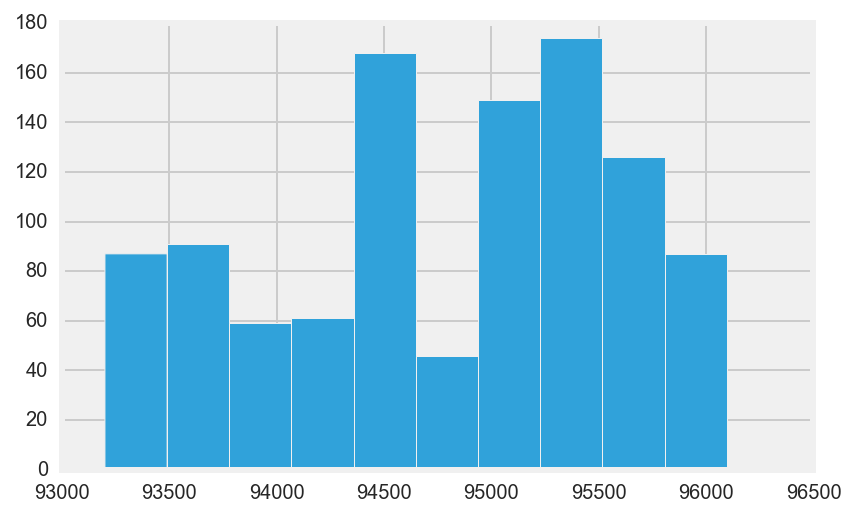

In [758]:
pge_q_num.ZipCode.hist()

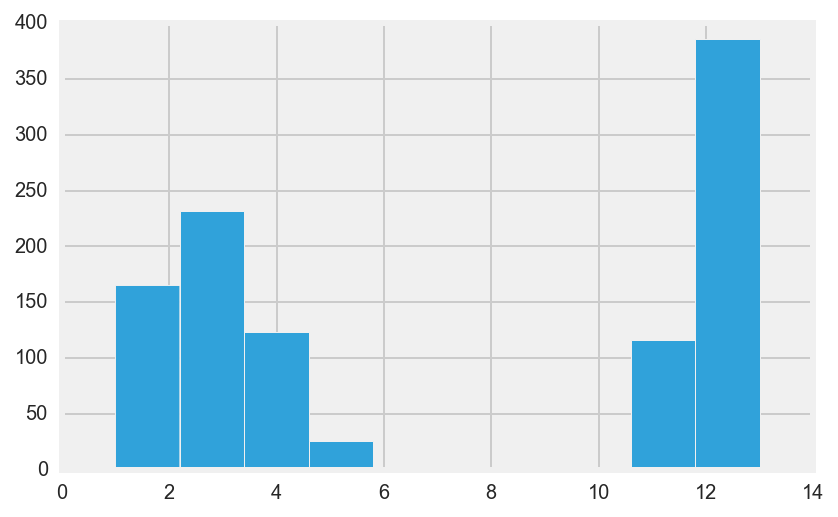

In [759]:
pge_q_num.zone.hist()

In [760]:
pge_q_num_corr  =  pge_q_num.corr()
pge_q_num_corr

,ZipCode,Month,CustomerClass,Combined,TotalCustomers,TotalkWh,AveragekWh,zone,avg_temp
ZipCode,1.000000,-0.014851,0.116348,NaN,-0.135939,-0.144310,-0.062322,-0.023850,-0.084219
Month,-0.014851,1.000000,-0.036159,NaN,-0.020913,0.067610,0.049808,0.029109,0.030987
CustomerClass,0.116348,-0.036159,1.000000,NaN,0.298930,-0.247595,-0.639528,0.105491,0.083181
Combined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotalCustomers,-0.135939,-0.020913,0.298930,NaN,1.000000,0.563867,-0.308075,-0.052430,-0.001672
TotalkWh,-0.144310,0.067610,-0.247595,NaN,0.563867,1.000000,0.377484,0.045366,0.105596
AveragekWh,-0.062322,0.049808,-0.639528,NaN,-0.308075,0.377484,1.000000,0.009984,0.035974
zone,-0.023850,0.029109,0.105491,NaN,-0.052430,0.045366,0.009984,1.000000,0.865388
avg_temp,-0.084219,0.030987,0.083181,NaN,-0.001672,0.105596,0.035974,0.865388,1.000000


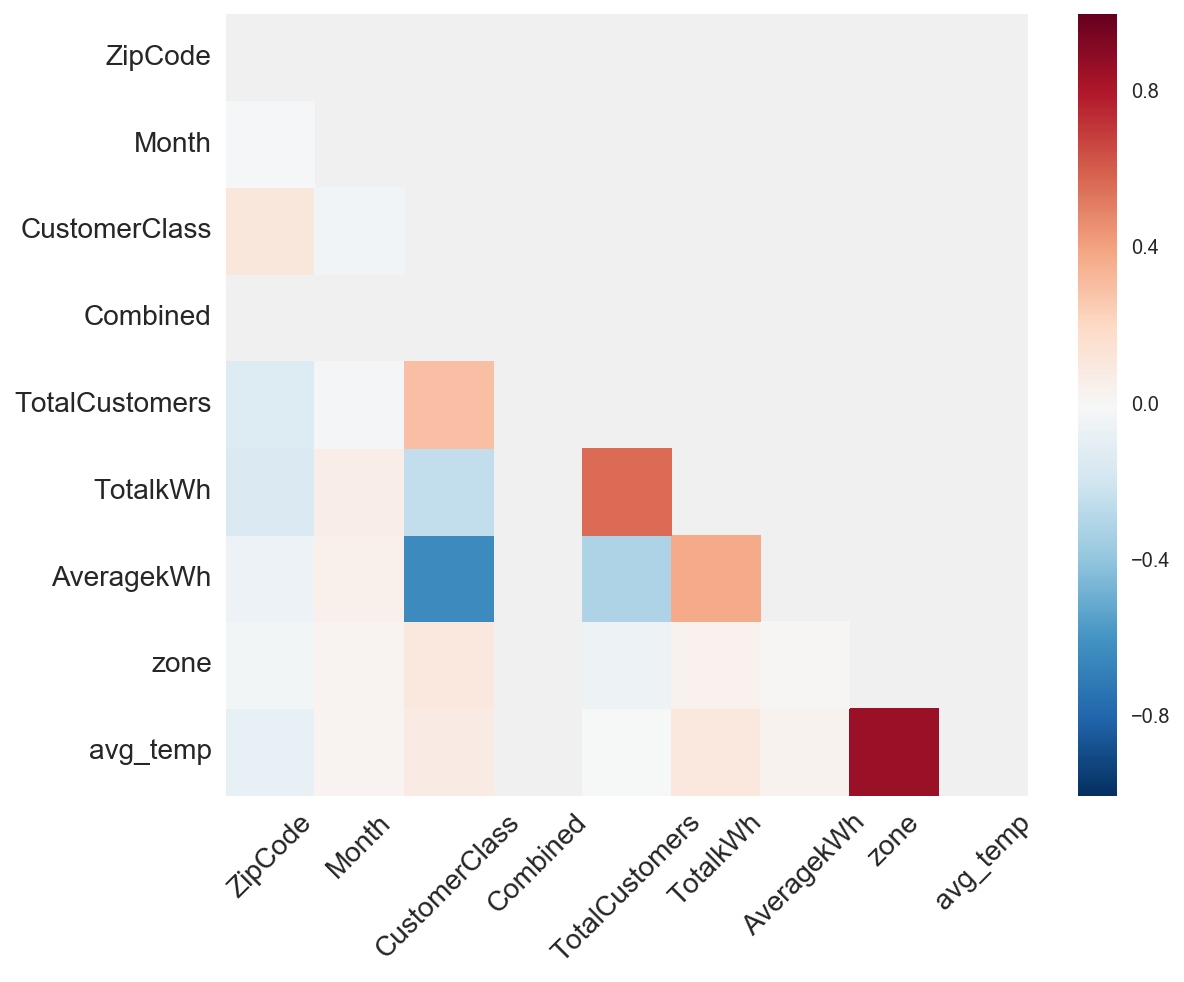

In [761]:
mask = np.zeros_like(pge_q_num_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(pge_q_num_corr, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

In [762]:
ca_solar_df_num['avg_temp'] = ca_solar_df_num['zone'].map(ca_2015_1_12_ave_dict)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [763]:
ca_solar_df_num.dropna(inplace=True)

/Users/Ovid/anaconda2/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [764]:
ca_solar_df_num.head(3)

,Nameplate Rating,CEC PTC Rating,CSI Rating,ZIP,zone,avg_temp
57439,3.38,2.991,2.853,95946,11.0,60.483333
14776,2.87,2.440,2.286,94044,3.0,57.250000
17331,3.43,2.968,2.089,94114,3.0,57.250000


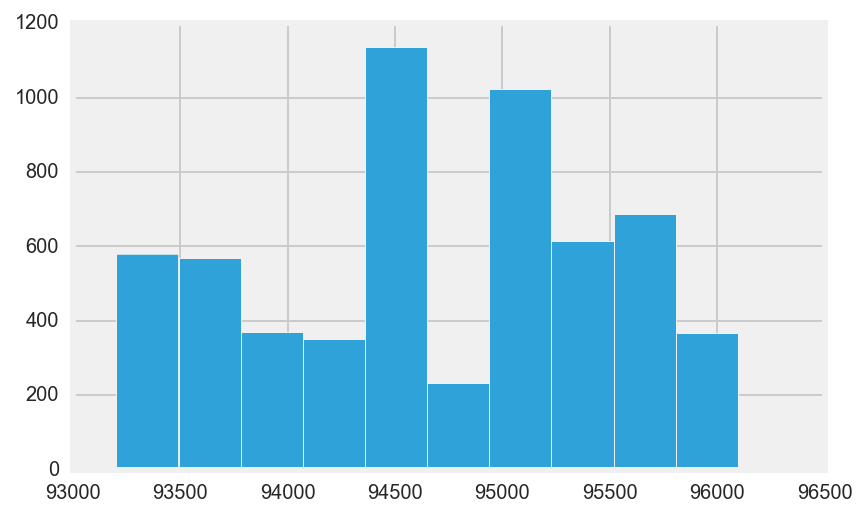

In [765]:
ca_solar_df_num.ZIP.hist()

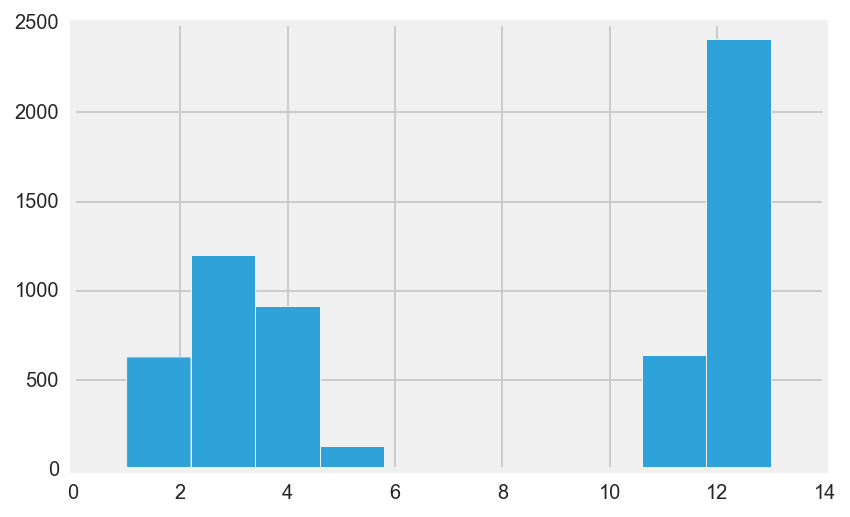

In [766]:
ca_solar_df_num.zone.hist()

In [767]:
ca_solar_df_num_corr  =  ca_solar_df_num.corr()
ca_solar_df_num_corr

,Nameplate Rating,CEC PTC Rating,CSI Rating,ZIP,zone,avg_temp
Nameplate Rating,1.000000,0.999868,0.988478,-0.015240,0.031938,0.038332
CEC PTC Rating,0.999868,1.000000,0.988637,-0.015189,0.032492,0.038696
CSI Rating,0.988478,0.988637,1.000000,-0.020148,0.034308,0.040719
ZIP,-0.015240,-0.015189,-0.020148,1.000000,-0.073090,-0.114493
zone,0.031938,0.032492,0.034308,-0.073090,1.000000,0.844138
avg_temp,0.038332,0.038696,0.040719,-0.114493,0.844138,1.000000


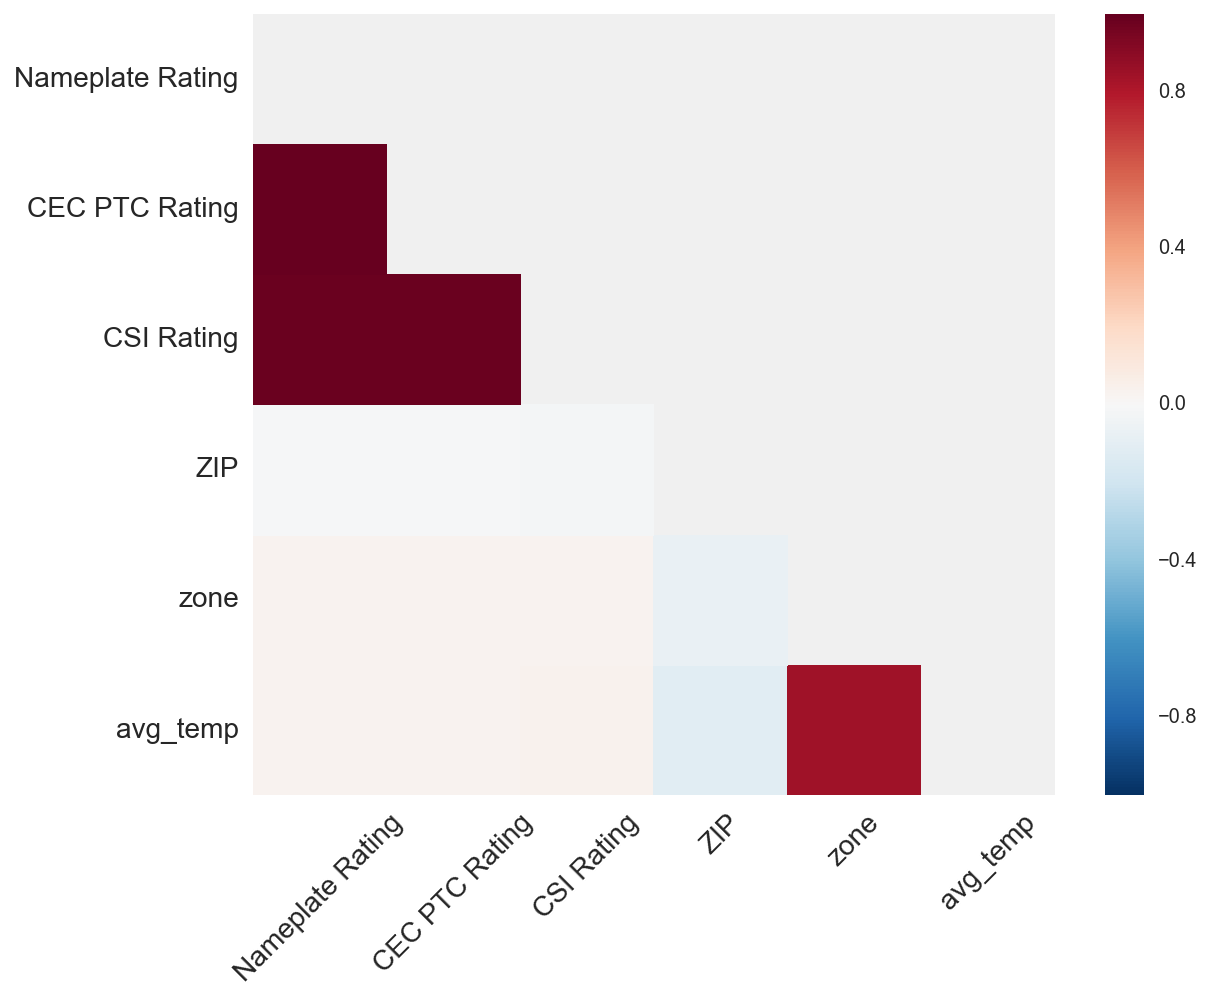

In [768]:
mask = np.zeros_like(ca_solar_df_num_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(ca_solar_df_num_corr, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()